In [105]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from scipy import stats
import seaborn as sns
import powerlaw
from scipy.stats import poisson
from scipy.stats import norm  
from sklearn.model_selection import train_test_split
import math
from random import shuffle
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
#from fa2 import ForceAtlas2
from scipy.spatial.distance import squareform
import joblib
import matplotlib
from sklearn.utils import column_or_1d
from sklearn.utils.multiclass import type_of_target
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.size'] = 15
from maximumentropymodels import *
import argparse

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator

from logger import Logger

import numpy as np

import pandas as pd

import networkx as nx
from tqdm import tqdm
from scipy.spatial.distance import squareform
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split

from scipy import sparse
import dask.array as da

from sklearn import metrics
from sklearn.metrics import average_precision_score


# logistic regression for feature importance
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

import os
import os.path
from scipy import linalg
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
import pickle

from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import normalize

In [106]:
dataset = PygLinkPropPredDataset(name='ogbl-ddi')
split_edge = dataset.get_edge_split()
data = dataset[0]

#device = f'cuda:{args.device}' if torch.cuda.is_available() else 'cpu'
#device = torch.device(device)
device = 'cpu'

x = data.x
pos_train_edge = split_edge['train']['edge'].to(device)
pos_valid_edge = split_edge['valid']['edge'].to(device)
neg_valid_edge = split_edge['valid']['edge_neg'].to(device)
pos_test_edge = split_edge['test']['edge'].to(device)
neg_test_edge = split_edge['test']['edge_neg'].to(device)

pos_train_edge_df = pd.DataFrame(pos_train_edge.numpy())
pos_valid_edge_df = pd.DataFrame(pos_valid_edge.numpy())
neg_valid_edge_df = pd.DataFrame(neg_valid_edge.numpy())
pos_test_edge_df = pd.DataFrame(pos_test_edge.numpy())
neg_test_edge_df = pd.DataFrame(neg_test_edge.numpy())

# Whole network

In [107]:
G_ddi = nx.from_pandas_edgelist(pd.concat([pos_train_edge_df,pos_valid_edge_df,pos_test_edge_df]), 0, 1, create_using=nx.Graph()) ## Whole graph

In [108]:
N = G_ddi.number_of_nodes()

In [109]:
netpos=nx.to_pandas_edgelist(G_ddi, source=0, target=1)
netpos['binary_label']=[1 for c in range(netpos.shape[0])]
print('density ', 2*len(G_ddi.edges)/N/(N-1)) 
print('Positive Edgelist ', netpos.shape[0])
Gc=nx.complement(G_ddi)
print('Total Neg Edgelist ', len(Gc.edges))
print('density ', 2*len(Gc.edges)/N/(N-1)) 
    
netneg=nx.to_pandas_edgelist(Gc, source='node_1', target='node_2').sample(n=len(G_ddi.edges))
    
netneg['binary_label']=[0 for c in range(netneg.shape[0])]
print('Negative Edgelist ', netneg.shape[0])
network_data=pd.concat([netpos, netneg])

density  0.1466667457744104
Positive Edgelist  1334889
Total Neg Edgelist  7766622
density  0.8533332542255895
Negative Edgelist  1334889


In [110]:
all_nodes = list(G_ddi.nodes())
print('Nodes in the network: ', len(all_nodes))

Nodes in the network:  4267


In [111]:
degree_nodes = dict(G_ddi.degree())

In [213]:
#clustering_coeff = nx.clustering(G_ddi)

In [214]:
#triangle_nodes = dict(nx.triangles(G_ddi))

In [112]:
nn_degree = nx.average_neighbor_degree(G_ddi)

In [216]:
#load_centrality_nodes = nx.load_centrality(G_ddi)

In [217]:
#betweenness_cetrality = dict(nx.betweenness_centrality(G_ddi))

In [113]:
#with open('clustering_coeff.pickle', 'wb') as handle:
#    pickle.dump(clustering_coeff, handle, protocol=pickle.HIGHEST_PROTOCOL)
       
#with open('triangle_nodes.pickle', 'wb') as handle:
#    pickle.dump(triangle_nodes, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
#with open('load_centrality_nodes.pickle', 'wb') as handle:
#    pickle.dump(load_centrality_nodes, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
#with open('betweenness_cetrality.pickle', 'wb') as handle:
#    pickle.dump(betweenness_cetrality, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('clustering_coeff_train.pickle', 'rb') as handle:
    clustering_coeff = pickle.load(handle)

with open('triangle_nodes_train.pickle', 'rb') as handle:
    triangle_nodes = pickle.load(handle)
    
with open('betweenness_cetrality_train.pickle', 'rb') as handle:
    betweenness_cetrality = pickle.load(handle)

# All 5 features

In [114]:
node_feature_dict = dict()

for node in tqdm(all_nodes):
    node_feat_list = []
    node_feat_list.append(degree_nodes[node])
    node_feat_list.append(clustering_coeff[node])
    #node_feat_list.append(nx.triangles(G_ddi,node))
    node_feat_list.append(triangle_nodes[node])
    node_feat_list.append(nn_degree[node])
    #node_feat_list.append(load_centrality_nodes[node])
    node_feat_list.append(betweenness_cetrality[node])
    #node_feat_list.append(betweenness_cetrality[node])
    node_feature_dict[node] = node_feat_list

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4267/4267 [00:00<00:00, 826007.07it/s]


In [115]:
network_data = network_data[[0,1,'binary_label']]

In [116]:
feature_edge_list = np.zeros((len(network_data),2*5))
i = 0

for index, row in tqdm(network_data.iterrows()):
    try:
        feature_edge_list[i,:] = np.log(np.concatenate((np.array(node_feature_dict[row[0]]),np.array(node_feature_dict[row[1]]))))
    except:
        feature_edge_list[i,:] =  np.log(np.random.rand(2*5,))
    i = i + 1

39449it [00:03, 11225.38it/s]/home/chatterjee.ay/.conda/envs/topology/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
2669778it [03:42, 11975.87it/s]


In [117]:
X = feature_edge_list
X[X == -inf] = 0
#X = normalize(X, axis=1, norm='l2')
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = np.array(network_data['binary_label'].tolist())

Feature: 0, Score: 2.35066
Feature: 1, Score: -0.32733
Feature: 2, Score: 1.75847
Feature: 3, Score: 3.44146
Feature: 4, Score: -2.33416
Feature: 5, Score: 1.31951
Feature: 6, Score: 0.59497
Feature: 7, Score: 0.95282
Feature: 8, Score: 2.42524
Feature: 9, Score: -0.81449


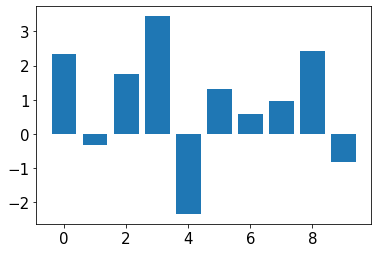

In [118]:
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# W/O NN-degree

In [119]:
node_feature_dict = dict()

for node in tqdm(all_nodes):
    node_feat_list = []
    node_feat_list.append(degree_nodes[node])
    node_feat_list.append(clustering_coeff[node])
    #node_feat_list.append(nx.triangles(G_ddi,node))
    node_feat_list.append(triangle_nodes[node])
    #node_feat_list.append(nn_degree[node])
    #node_feat_list.append(load_centrality_nodes[node])
    node_feat_list.append(betweenness_cetrality[node])
    #node_feat_list.append(betweenness_cetrality[node])
    node_feature_dict[node] = node_feat_list

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4267/4267 [00:00<00:00, 891689.26it/s]


In [120]:
network_data = network_data[[0,1,'binary_label']]

In [121]:
feature_edge_list = np.zeros((len(network_data),2*4))
i = 0

for index, row in tqdm(network_data.iterrows()):
    try:
        feature_edge_list[i,:] = np.log(np.concatenate((np.array(node_feature_dict[row[0]]),np.array(node_feature_dict[row[1]]))))
    except:
        feature_edge_list[i,:] =  np.log(np.random.rand(2*4,))
    i = i + 1

39053it [00:03, 10410.12it/s]/home/chatterjee.ay/.conda/envs/topology/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
2669778it [03:43, 11919.13it/s]


In [122]:
X = feature_edge_list
X[X == -inf] = 0
#X = normalize(X, axis=1, norm='l2')
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = np.array(network_data['binary_label'].tolist())

Feature: 0, Score: 5.63655
Feature: 1, Score: -0.41661
Feature: 2, Score: 3.41488
Feature: 3, Score: -3.20777
Feature: 4, Score: 2.34202
Feature: 5, Score: 1.03336
Feature: 6, Score: 1.22427
Feature: 7, Score: -1.25512


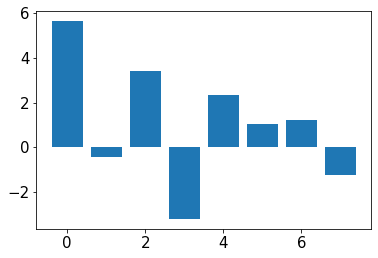

In [123]:
# define dataset
#X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Run prediction task all features

## Train

In [124]:
G_ddi = nx.from_pandas_edgelist(pos_train_edge_df, 0, 1, create_using=nx.Graph()) ## Whole graph

In [125]:
N = G_ddi.number_of_nodes()

In [126]:
netpos=nx.to_pandas_edgelist(G_ddi, source=0, target=1)
netpos['binary_label']=[1 for c in range(netpos.shape[0])]
print('density ', 2*len(G_ddi.edges)/N/(N-1)) 
print('Positive Edgelist ', netpos.shape[0])
Gc=nx.complement(G_ddi)
print('Total Neg Edgelist ', len(Gc.edges))
print('density ', 2*len(Gc.edges)/N/(N-1)) 
    
#if typeneg=='real':
#netneg=nx.to_pandas_edgelist(Gc, source='node_1', target='node_2')
#elif typeneg=='equal':
netneg=nx.to_pandas_edgelist(Gc, source='node_1', target='node_2').sample(n=len(G_ddi.edges))
#else:
#    return
    
netneg['binary_label']=[0 for c in range(netneg.shape[0])]
print('Negative Edgelist ', netneg.shape[0])
network_data=pd.concat([netpos, netneg])

density  0.11733337464515507
Positive Edgelist  1067911
Total Neg Edgelist  8033600
density  0.882666625354845
Negative Edgelist  1067911


In [127]:
all_nodes = list(G_ddi.nodes())
print('Nodes in the network: ', len(all_nodes))

Nodes in the network:  4267


In [128]:
degree_nodes = dict(G_ddi.degree())

In [8]:
#clustering_coeff = nx.clustering(G_ddi)

In [9]:
#triangle_nodes = dict(nx.triangles(G_ddi))

In [10]:
#nn_degree = nx.average_neighbor_degree(G_ddi)

In [14]:
#load_centrality_nodes = nx.load_centrality(G_ddi)

In [15]:
#betweenness_cetrality = dict(nx.betweenness_centrality(G_ddi))

In [129]:
#with open('clustering_coeff_train.pickle', 'wb') as handle:
#    pickle.dump(clustering_coeff, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
#with open('triangle_nodes_train.pickle', 'wb') as handle:
#    pickle.dump(triangle_nodes, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
#with open('load_centrality_nodes_train.pickle', 'wb') as handle:
#    pickle.dump(load_centrality_nodes, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
#with open('betweenness_cetrality_train.pickle', 'wb') as handle:
#    pickle.dump(betweenness_cetrality, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('clustering_coeff_train.pickle', 'rb') as handle:
    clustering_coeff = pickle.load(handle)

with open('triangle_nodes_train.pickle', 'rb') as handle:
    triangle_nodes = pickle.load(handle)
    
with open('betweenness_cetrality_train.pickle', 'rb') as handle:
    betweenness_cetrality = pickle.load(handle)

In [130]:
network_data = network_data[[0,1,'binary_label']]

In [131]:
node_feature_dict = dict()

for node in tqdm(all_nodes):
    node_feat_list = []
    node_feat_list.append(degree_nodes[node])
    node_feat_list.append(clustering_coeff[node])
    #node_feat_list.append(nx.triangles(G_ddi,node))
    node_feat_list.append(triangle_nodes[node])
    #node_feat_list.append(nn_degree[node])
    #node_feat_list.append(load_centrality_nodes[node])
    node_feat_list.append(betweenness_cetrality[node])
    #node_feat_list.append(betweenness_cetrality[node])
    node_feature_dict[node] = node_feat_list

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4267/4267 [00:00<00:00, 299242.50it/s]


In [132]:
feature_edge_list = np.zeros((len(network_data),2*4))
i = 0

for index, row in tqdm(network_data.iterrows()):
    try:
        feature_edge_list[i,:] = np.log(np.concatenate((np.array(node_feature_dict[row[0]]),np.array(node_feature_dict[row[1]]))))
    except:
        feature_edge_list[i,:] =  np.log(np.random.rand(2*4,))
    i = i + 1

31015it [00:02, 10974.70it/s]/home/chatterjee.ay/.conda/envs/topology/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
2135822it [02:59, 11921.89it/s]


In [133]:
X = np.array(feature_edge_list)
X[X == -inf] = 0
#X = normalize(X, axis=1, norm='l2')
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = np.array(network_data['binary_label'].tolist())

Feature: 0, Score: 5.39508
Feature: 1, Score: -0.41293
Feature: 2, Score: 3.36869
Feature: 3, Score: -3.37290
Feature: 4, Score: 2.42276
Feature: 5, Score: 1.01944
Feature: 6, Score: 1.18260
Feature: 7, Score: -1.22630


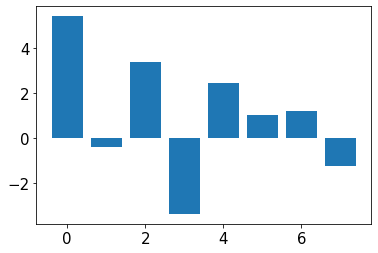

In [134]:
# define dataset
#X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Test

In [135]:
G_ddi_test = nx.from_pandas_edgelist(pos_test_edge_df, 0, 1, create_using=nx.Graph()) ## Whole graph

In [136]:
N = G_ddi_test.number_of_nodes()

In [137]:
netpos=nx.to_pandas_edgelist(G_ddi_test, source=0, target=1)
netpos['binary_label']=[1 for c in range(netpos.shape[0])]
print('density ', 2*len(G_ddi_test.edges)/N/(N-1)) 
print('Positive Edgelist ', netpos.shape[0])
#Gc=nx.complement(G_ddi_test)
#print('Total Neg Edgelist ', len(Gc.edges))
#print('density ', 2*len(Gc.edges)/N/(N-1)) 
    
#if typeneg=='real':
#netneg=nx.to_pandas_edgelist(Gc, source='node_1', target='node_2')
#elif typeneg=='equal':
netneg = neg_test_edge_df.rename(columns={0:'node_1',1:'node_2'}) #nx.to_pandas_edgelist(Gc, source='node_1', target='node_2').sample(n=len(G_ddi_test.edges))
#else:
#    return
    
netneg['binary_label']=[0 for c in range(netneg.shape[0])]
print('Negative Edgelist ', netneg.shape[0])
network_data_test =pd.concat([netpos, netneg])

density  0.10280515623820724
Positive Edgelist  133489
Negative Edgelist  95599


In [138]:
all_nodes = list(G_ddi_test.nodes())
print('Nodes in the network: ', len(all_nodes))

Nodes in the network:  1612


In [139]:
degree_nodes = dict(G_ddi_test.degree())

In [27]:
#clustering_coeff = nx.clustering(G_ddi_test)

In [28]:
#triangle_nodes = dict(nx.triangles(G_ddi_test))

In [29]:
#nn_degree = nx.average_neighbor_degree(G_ddi_test)

In [30]:
#load_centrality_nodes = nx.load_centrality(G_ddi_test)

In [ ]:
#betweenness_cetrality = dict(nx.betweenness_centrality(G_ddi_test))

In [140]:
#with open('clustering_coeff_test.pickle', 'wb') as handle:
#    pickle.dump(clustering_coeff, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
#with open('triangle_nodes_test.pickle', 'wb') as handle:
#    pickle.dump(triangle_nodes, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
#with open('load_centrality_nodes_test.pickle', 'wb') as handle:
#    pickle.dump(load_centrality_nodes, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
#with open('betweenness_cetrality_test.pickle', 'wb') as handle:
#    pickle.dump(betweenness_cetrality, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('clustering_coeff_test.pickle', 'rb') as handle:
    clustering_coeff = pickle.load(handle)

with open('triangle_nodes_test.pickle', 'rb') as handle:
    triangle_nodes = pickle.load(handle)
    
with open('betweenness_cetrality_test.pickle', 'rb') as handle:
    betweenness_cetrality = pickle.load(handle)

In [43]:
network_data_test = network_data_test[[0,1,'binary_label']]

In [44]:
node_feature_dict = dict()

for node in tqdm(all_nodes):
    node_feat_list = []
    node_feat_list.append(degree_nodes[node])
    node_feat_list.append(clustering_coeff[node])
    #node_feat_list.append(nx.triangles(G_ddi,node))
    node_feat_list.append(triangle_nodes[node])
    #node_feat_list.append(nn_degree[node])
    #node_feat_list.append(load_centrality_nodes[node])
    node_feat_list.append(betweenness_cetrality[node])
    #node_feat_list.append(betweenness_cetrality[node])
    node_feature_dict[node] = node_feat_list

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1612/1612 [00:00<00:00, 741768.30it/s]


In [46]:
feature_edge_list = np.zeros((len(network_data_test),2*4))
i = 0

for index, row in tqdm(network_data_test.iterrows()):
    try:
        feature_edge_list[i,:] = np.log(np.concatenate((np.array(node_feature_dict[row[0]]),np.array(node_feature_dict[row[1]]))))
    except:
        feature_edge_list[i,:] =  np.log(np.random.rand(2*4,))
    i = i + 1

9674it [00:00, 10199.98it/s]/home/chatterjee.ay/.conda/envs/topology/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
229088it [00:19, 11573.14it/s]


In [47]:
X_test = np.array(feature_edge_list)
X_test[X_test == -inf] = 0
#X = normalize(X, axis=1, norm='l2')
X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)
y_test = np.array(network_data_test['binary_label'].tolist())

In [48]:
y_predicted = model.predict(X_test)

In [49]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
print(metrics.auc(fpr, tpr))

1.0


In [50]:
average_precision_score(y_test, y_predicted)

1.0

# Run predictions w/o degree 

# Train

In [61]:
all_nodes = list(G_ddi.nodes())
print('Nodes in the network: ', len(all_nodes))

Nodes in the network:  4267


In [62]:
degree_nodes = dict(G_ddi.degree())

In [53]:
#clustering_coeff = nx.clustering(G_ddi)

In [54]:
#triangle_nodes = dict(nx.triangles(G_ddi))

In [55]:
#nn_degree = nx.average_neighbor_degree(G_ddi)

In [56]:
#load_centrality_nodes = nx.load_centrality(G_ddi)

In [57]:
#betweenness_cetrality = dict(nx.betweenness_centrality(G_ddi))

In [63]:
with open('clustering_coeff_train.pickle', 'rb') as handle:
    clustering_coeff = pickle.load(handle)

with open('triangle_nodes_train.pickle', 'rb') as handle:
    triangle_nodes = pickle.load(handle)
    
with open('betweenness_cetrality_train.pickle', 'rb') as handle:
    betweenness_cetrality = pickle.load(handle)

In [64]:
network_data = network_data[[0,1,'binary_label']]

In [65]:
node_feature_dict = dict()

for node in tqdm(all_nodes):
    node_feat_list = []
    #node_feat_list.append(degree_nodes[node])
    node_feat_list.append(clustering_coeff[node])
    #node_feat_list.append(nx.triangles(G_ddi,node))
    node_feat_list.append(triangle_nodes[node])
    #node_feat_list.append(nn_degree[node])
    #node_feat_list.append(load_centrality_nodes[node])
    node_feat_list.append(betweenness_cetrality[node])
    #node_feat_list.append(betweenness_cetrality[node])
    node_feature_dict[node] = node_feat_list

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4267/4267 [00:00<00:00, 957780.97it/s]


In [66]:
feature_edge_list = np.zeros((len(network_data),2*3))
i = 0

for index, row in tqdm(network_data.iterrows()):
    try:
        feature_edge_list[i,:] = np.log(np.concatenate((np.array(node_feature_dict[row[0]]),np.array(node_feature_dict[row[1]]))))
    except:
        feature_edge_list[i,:] =  np.log(np.random.rand(2*3,))
    i = i + 1

29597it [00:01, 22360.37it/s]/home/chatterjee.ay/.conda/envs/topology/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
2135822it [01:28, 24110.62it/s]


In [67]:
X = np.array(feature_edge_list)
X[X == -inf] = 0
#X = normalize(X, axis=1, norm='l2')
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = np.array(network_data['binary_label'].tolist())

Feature: 0, Score: -0.40489
Feature: 1, Score: 7.84032
Feature: 2, Score: -3.81754
Feature: 3, Score: 1.02554
Feature: 4, Score: 2.57870
Feature: 5, Score: -1.95383


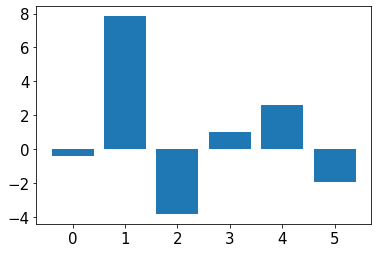

In [68]:
# define dataset
#X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Test

In [69]:
degree_nodes = dict(G_ddi_test.degree())

In [126]:
#clustering_coeff = nx.clustering(G_ddi_test)

In [127]:
#triangle_nodes = dict(nx.triangles(G_ddi_test))

In [128]:
#nn_degree = nx.average_neighbor_degree(G_ddi_test)

In [129]:
#load_centrality_nodes = nx.load_centrality(G_ddi_test)

In [130]:
#betweenness_cetrality = dict(nx.betweenness_centrality(G_ddi_test))

In [70]:
with open('clustering_coeff_test.pickle', 'rb') as handle:
    clustering_coeff = pickle.load(handle)

with open('triangle_nodes_test.pickle', 'rb') as handle:
    triangle_nodes = pickle.load(handle)
    
with open('betweenness_cetrality_test.pickle', 'rb') as handle:
    betweenness_cetrality = pickle.load(handle)

In [71]:
network_data_test = network_data_test[[0,1,'binary_label']]

In [72]:
all_nodes = list(G_ddi_test.nodes())
print('Nodes in the network: ', len(all_nodes))

Nodes in the network:  1612


In [73]:
node_feature_dict = dict()

for node in tqdm(all_nodes):
    node_feat_list = []
    #node_feat_list.append(degree_nodes[node])
    node_feat_list.append(clustering_coeff[node])
    #node_feat_list.append(nx.triangles(G_ddi,node))
    node_feat_list.append(triangle_nodes[node])
    #node_feat_list.append(nn_degree[node])
    #node_feat_list.append(load_centrality_nodes[node])
    node_feat_list.append(betweenness_cetrality[node])
    #node_feat_list.append(betweenness_cetrality[node])
    node_feature_dict[node] = node_feat_list

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1612/1612 [00:00<00:00, 776081.04it/s]


In [77]:
feature_edge_list = np.zeros((len(network_data_test),2*3))
i = 0

for index, row in tqdm(network_data_test.iterrows()):
    try:
        feature_edge_list[i,:] = np.log(np.concatenate((np.array(node_feature_dict[row[0]]),np.array(node_feature_dict[row[1]]))))
    except:
        feature_edge_list[i,:] =  np.log(np.random.rand(2*3,))
    i = i + 1

8460it [00:00, 21258.57it/s]/home/chatterjee.ay/.conda/envs/topology/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
229088it [00:09, 23658.60it/s]


In [78]:
X_test = np.array(feature_edge_list)
X_test[X_test == -inf] = 0
#X = normalize(X, axis=1, norm='l2')
X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)
y_test = np.array(network_data_test['binary_label'].tolist())

In [79]:
y_predicted = model.predict(X_test)

In [80]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
print(metrics.auc(fpr, tpr))

1.0


In [81]:
average_precision_score(y_test, y_predicted)

1.0

# Run predictions w/o degree and traingle count

# Train

In [82]:
all_nodes = list(G_ddi.nodes())
print('Nodes in the network: ', len(all_nodes))

Nodes in the network:  4267


In [83]:
degree_nodes = dict(G_ddi.degree())

In [8]:
#clustering_coeff = nx.clustering(G_ddi)

In [9]:
#triangle_nodes = dict(nx.triangles(G_ddi))

In [10]:
#nn_degree = nx.average_neighbor_degree(G_ddi)

In [14]:
#load_centrality_nodes = nx.load_centrality(G_ddi)

In [15]:
#betweenness_cetrality = dict(nx.betweenness_centrality(G_ddi))

In [84]:
with open('clustering_coeff_train.pickle', 'rb') as handle:
    clustering_coeff = pickle.load(handle)

with open('triangle_nodes_train.pickle', 'rb') as handle:
    triangle_nodes = pickle.load(handle)
    
with open('betweenness_cetrality_train.pickle', 'rb') as handle:
    betweenness_cetrality = pickle.load(handle)
    

In [85]:
network_data = network_data[[0,1,'binary_label']]

In [86]:
node_feature_dict = dict()

for node in tqdm(all_nodes):
    node_feat_list = []
    #node_feat_list.append(degree_nodes[node])
    node_feat_list.append(clustering_coeff[node])
    #node_feat_list.append(nx.triangles(G_ddi,node))
    #node_feat_list.append(triangle_nodes[node])
    #node_feat_list.append(nn_degree[node])
    #node_feat_list.append(load_centrality_nodes[node])
    node_feat_list.append(betweenness_cetrality[node])
    #node_feat_list.append(betweenness_cetrality[node])
    node_feature_dict[node] = node_feat_list

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4267/4267 [00:00<00:00, 952784.03it/s]


In [87]:
feature_edge_list = np.zeros((len(network_data),2*2))
i = 0

for index, row in tqdm(network_data.iterrows()):
    try:
        feature_edge_list[i,:] = np.log(np.concatenate((np.array(node_feature_dict[row[0]]),np.array(node_feature_dict[row[1]]))))
    except:
        feature_edge_list[i,:] =  np.log(np.random.rand(2*2,))
    i = i + 1

29971it [00:01, 23369.80it/s]/home/chatterjee.ay/.conda/envs/topology/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
2135822it [01:28, 24153.29it/s]


In [88]:
X = np.array(feature_edge_list)
X[X == -inf] = 0
#X = normalize(X, axis=1, norm='l2')
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = np.array(network_data['binary_label'].tolist())

Feature: 0, Score: -0.13047
Feature: 1, Score: -8.19349
Feature: 2, Score: 0.10736
Feature: 3, Score: -8.42699


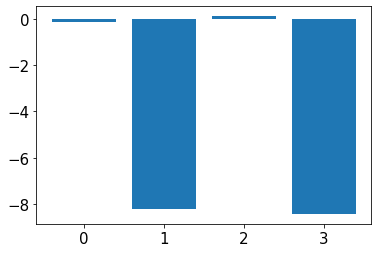

In [89]:
# define dataset
#X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Test

In [90]:
degree_nodes = dict(G_ddi_test.degree())

In [91]:
#clustering_coeff = nx.clustering(G_ddi_test)

In [92]:
#triangle_nodes = dict(nx.triangles(G_ddi_test))

In [93]:
#nn_degree = nx.average_neighbor_degree(G_ddi_test)

In [94]:
#load_centrality_nodes = nx.load_centrality(G_ddi_test)

In [95]:
#betweenness_cetrality = dict(nx.betweenness_centrality(G_ddi_test))

In [96]:
with open('clustering_coeff_test.pickle', 'rb') as handle:
    clustering_coeff = pickle.load(handle)

with open('triangle_nodes_test.pickle', 'rb') as handle:
    triangle_nodes = pickle.load(handle)
    
with open('betweenness_cetrality_test.pickle', 'rb') as handle:
    betweenness_cetrality = pickle.load(handle)

In [97]:
network_data_test = network_data_test[[0,1,'binary_label']]

In [98]:
all_nodes = list(G_ddi_test.nodes())
print('Nodes in the network: ', len(all_nodes))

Nodes in the network:  1612


In [99]:
node_feature_dict = dict()

for node in tqdm(all_nodes):
    node_feat_list = []
    #node_feat_list.append(degree_nodes[node])
    node_feat_list.append(clustering_coeff[node])
    #node_feat_list.append(nx.triangles(G_ddi,node))
    #node_feat_list.append(triangle_nodes[node])
    #node_feat_list.append(nn_degree[node])
    #node_feat_list.append(load_centrality_nodes[node])
    node_feat_list.append(betweenness_cetrality[node])
    #node_feat_list.append(betweenness_cetrality[node])
    node_feature_dict[node] = node_feat_list

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1612/1612 [00:00<00:00, 825344.00it/s]


In [100]:
feature_edge_list = np.zeros((len(network_data_test),2*2))
i = 0

for index, row in tqdm(network_data_test.iterrows()):
    try:
        feature_edge_list[i,:] = np.log(np.concatenate((np.array(node_feature_dict[row[0]]),np.array(node_feature_dict[row[1]]))))
    except:
        feature_edge_list[i,:] =  np.log(np.random.rand(2*2,))
    i = i + 1

8835it [00:00, 21802.65it/s]/home/chatterjee.ay/.conda/envs/topology/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
229088it [00:09, 23665.42it/s]


In [101]:
X_test = np.array(feature_edge_list)
X_test[X_test == -inf] = 0
#X = normalize(X, axis=1, norm='l2')
X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)
y_test = np.array(network_data_test['binary_label'].tolist())

In [102]:
y_predicted = model.predict(X_test)

In [103]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
print(metrics.auc(fpr, tpr))

0.9993447207415228


In [104]:
average_precision_score(y_test, y_predicted)

0.9994062214789877

# Run predictions w/ only degree

# Train

In [229]:
all_nodes = list(G_ddi.nodes())
print('Nodes in the network: ', len(all_nodes))

Nodes in the network:  4267


In [230]:
degree_nodes = dict(G_ddi.degree())

In [8]:
#clustering_coeff = nx.clustering(G_ddi)

In [9]:
#triangle_nodes = dict(nx.triangles(G_ddi))

In [10]:
#nn_degree = nx.average_neighbor_degree(G_ddi)

In [14]:
#load_centrality_nodes = nx.load_centrality(G_ddi)

In [15]:
#betweenness_cetrality = dict(nx.betweenness_centrality(G_ddi))

In [231]:
with open('clustering_coeff_train.pickle', 'rb') as handle:
    clustering_coeff = pickle.load(handle)

with open('triangle_nodes_train.pickle', 'rb') as handle:
    triangle_nodes = pickle.load(handle)
    
with open('betweenness_cetrality_train.pickle', 'rb') as handle:
    betweenness_cetrality = pickle.load(handle)
    

In [232]:
network_data = network_data[[0,1,'binary_label']]

In [233]:
node_feature_dict = dict()

for node in tqdm(all_nodes):
    node_feat_list = []
    node_feat_list.append(degree_nodes[node])
    #node_feat_list.append(clustering_coeff[node])
    #node_feat_list.append(nx.triangles(G_ddi,node))
    #node_feat_list.append(triangle_nodes[node])
    #node_feat_list.append(nn_degree[node])
    #node_feat_list.append(load_centrality_nodes[node])
    #node_feat_list.append(betweenness_cetrality[node])
    #node_feat_list.append(betweenness_cetrality[node])
    node_feature_dict[node] = node_feat_list

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4267/4267 [00:00<00:00, 996997.11it/s]


In [234]:
feature_edge_list = np.zeros((len(network_data),1))
i = 0

for index, row in tqdm(network_data.iterrows()):
    try:
        feature_edge_list[i,:] = np.log((np.array(node_feature_dict[row[0]]) + np.array(node_feature_dict[row[1]]))/2)
    except:
        feature_edge_list[i,:] =  np.log(np.random.rand(1,))
    i = i + 1

2669778it [01:41, 26301.67it/s]


In [235]:
X = np.array(feature_edge_list)
X = normalize(X, axis=1, norm='l2')
y = np.array(network_data['binary_label'].tolist())

Feature: 0, Score: 12.28881


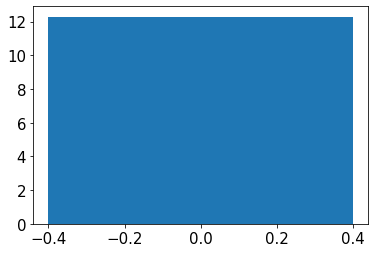

In [236]:
# define dataset
#X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Test

In [237]:
degree_nodes = dict(G_ddi_test.degree())

In [80]:
#clustering_coeff = nx.clustering(G_ddi_test)

In [81]:
#triangle_nodes = dict(nx.triangles(G_ddi_test))

In [82]:
#nn_degree = nx.average_neighbor_degree(G_ddi_test)

In [83]:
#load_centrality_nodes = nx.load_centrality(G_ddi_test)

In [84]:
#betweenness_cetrality = dict(nx.betweenness_centrality(G_ddi_test))

In [238]:
with open('clustering_coeff_test.pickle', 'rb') as handle:
    clustering_coeff = pickle.load(handle)

with open('triangle_nodes_test.pickle', 'rb') as handle:
    triangle_nodes = pickle.load(handle)
    
with open('betweenness_cetrality_test.pickle', 'rb') as handle:
    betweenness_cetrality = pickle.load(handle)

In [239]:
network_data_test = network_data_test[[0,1,'binary_label']]

In [240]:
all_nodes = list(G_ddi_test.nodes())
print('Nodes in the network: ', len(all_nodes))

Nodes in the network:  1612


In [241]:
node_feature_dict = dict()

for node in tqdm(all_nodes):
    node_feat_list = []
    node_feat_list.append(degree_nodes[node])
    #node_feat_list.append(clustering_coeff[node])
    #node_feat_list.append(nx.triangles(G_ddi,node))
    #node_feat_list.append(triangle_nodes[node])
    #node_feat_list.append(nn_degree[node])
    #node_feat_list.append(load_centrality_nodes[node])
    #node_feat_list.append(betweenness_cetrality[node])
    #node_feat_list.append(betweenness_cetrality[node])
    node_feature_dict[node] = node_feat_list

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1612/1612 [00:00<00:00, 1398390.50it/s]


In [242]:
feature_edge_list = np.zeros((len(network_data_test),1))
i = 0

for index, row in tqdm(network_data_test.iterrows()):
    try:
        feature_edge_list[i,:] = np.log((np.array(node_feature_dict[row[0]]) + np.array(node_feature_dict[row[1]]))/2)
    except:
        feature_edge_list[i,:] =  np.log(np.random.rand(1,))
    i = i + 1

229088it [00:08, 25586.22it/s]


In [243]:
X_test = np.array(feature_edge_list)
X_test = normalize(X_test, axis=1, norm='l2')
y_test = np.array(network_data_test['binary_label'].tolist())

In [244]:
y_predicted = model.predict(X_test)

In [245]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted)
print(metrics.auc(fpr, tpr))

1.0


In [246]:
average_precision_score(y_test, y_predicted)

1.0